### Imports and config

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import f1_score

#Properties
from utils import properties as p

#Utils
from utils import create_bins, one_hot, print_summary

#Model
import nn_model as nn

#Config
%config InlineBackend.figure_format='retina'

### Setup properties

In [2]:
p.update({
    
    #Age range
    'age_min' : 0,
    'age_max' : 49,
    
    #Number of data samples
    'data_samples' : 3000,
    
})

### Read data

In [3]:
df = pd.read_csv('../dataset/data.csv')

### Prepare dataset

In [4]:
def age_filter(df, age_min, age_max):
    return (df['age'] >= age_min) & (df['age'] <= age_max)

def ethnicity_gender_filter(df, i, j):
    return (df['ethnicity'] == p['ETHNICITIES'][i]) & (df['gender'] == p['GENDERS'][j])

def ethnicity_age_filter(df, e, age_min, age_max):
    return (df['ethnicity'] == p['ETHNICITIES'][e]) & age_filter(df, age_min, age_max)

def ethnicity_gender_age_filter(df, i, j, age_min, age_max):
    return ethnicity_gender_filter(df, i, j) & age_filter(df, age_min, age_max)

In [5]:
df = df.loc[age_filter(df, p['age_min'], p['age_max'])]
df['ethnicity'] = df['ethnicity'].map(p['ETHNICITIES'])
df['gender'] = df['gender'].map(p['GENDERS'])
df[p['feature_to_use']] = df[p['feature_to_use']]\
        .apply(lambda x: np.array(x.split(), dtype='float32'))

### Create balanced dataset

In [6]:
#Ethnicity gender age sample size
ethnicity_age_sample_size = round(p['data_samples'] / (round(p['age_range']() / p['age_bins']) * len(p['ETHNICITIES'])))

balanced_df = pd.concat([
    df.loc[ethnicity_age_filter(df, e, age_m, age_M)]\
        .sample(ethnicity_age_sample_size, random_state=p['seed'], replace=True)
    for e in range(len(p['ETHNICITIES']))
    #for j in range(len(GENDERS))
    for (age_m, age_M) in p['bins']()
])

### Create unbalanced dataset

In [7]:
min_factor = 0.05 # 5% of the population 
maj_factor = 1 - min_factor

#Size of minority group
min_sample_size = round(p['data_samples'] * min_factor / len(p['bins']()) / (len(p['ETHNICITIES']) - 1))

#Size of majority group
maj_sample_size = round(p['data_samples'] * maj_factor / len(p['GENDERS']) / len(p['bins']()))

white_male = pd.concat([
    df.loc[ethnicity_gender_age_filter(df, 0, 0, age_min, age_max)]\
        .sample(maj_sample_size, random_state=p['seed'], replace=True)
    for (age_min, age_max) in p['bins']()
])

white_female = pd.concat([
    df.loc[ethnicity_gender_age_filter(df, 0, 1, age_min, age_max)]\
        .sample(maj_sample_size, random_state=p['seed'], replace=True)
    for (age_min, age_max) in p['bins']()
])

unbalanced_df = pd.concat([
    df.loc[ethnicity_age_filter(df, e, age_min, age_max)]\
        .sample(min_sample_size, random_state=p['seed'], replace=True)
    for e in range(1, len(p['ETHNICITIES']))
    #for j in range(len(GENDERS))
    for (age_min, age_max) in p['bins']()
] + [white_female, white_male])

### Create Train-Test sets

In [8]:
def create_train_test(df, test_size=.2):
    return train_test_split(df, test_size=test_size, random_state=p['seed'])

def prepare_X(df):
    X = np.array(df[p['feature_to_use']].tolist())
    X = np.reshape(X, (-1, 1, 1, p['img_size'] * p['img_size'])) / p['color_channel']
    return X

def prepare_y(df):
    y = np.array(df[p['feature_to_predict']].apply(lambda x: one_hot(x, p['bins']())).tolist())
    y = np.reshape(y, (-1, 1, 1, len(p['bins']())))
    return y
    
def prepare_data(df_train, df_test):
    X_train = prepare_X(df_train)
    y_train = prepare_y(df_train)
    X_test = prepare_X(df_test)
    y_test = prepare_y(df_test)
    return X_train, y_train, X_test, y_test
    

#df_train, df_test = create_train_test(balanced_df)
#X_train, y_train, X_test, y_test = prepare_data(df_train, df_test)
#X_train.shape, y_train.shape, X_test.shape, y_test.shape

## Predictive Model

### Parameters

In [9]:
learning_rate = 0.05
epochs_n = 1

### Model

In [10]:
# network (not federated)

def standard_nn():
    return nn.get_standard_nn(p['seed'])

### Evaluate predictive model

In [11]:
def evaluate_ethnicity(dataset, ethnicity, df_test, model):
    idx_keys = dataset.index.intersection(df_test[df_test['ethnicity'] == ethnicity].index)
    ethn_df = dataset.loc[idx_keys]
    ethn_X = prepare_X(ethn_df)
    ethn_y = prepare_y(ethn_df)
    ethn_y_pred = model.predict(ethn_X)
    score = f1_score(convert_output(ethn_y), convert_output(ethn_y_pred), average='macro')
    return score

def evaluate_all_ethnicities(dataset, df_test, model):
    scores = [evaluate_ethnicity(dataset, e, df_test, model) for e in p['ETHNICITIES'].values()]
    return dict(zip(p['ETHNICITIES'].values(), scores))

def one_hot_to_num(oh):
    M = max(oh)
    return oh.index(M)

def convert_output(y_out):
    out = []
    for i in range(len(y_out)):
        label = one_hot_to_num(list(y_out[i][0][0]))
        out += [one_hot(label * p['age_bins'], p['bins']())]
    return out

### F1 Score
#### Params 
`macro`: Calculate metrics for each label, and find their unweighted mean. This does not take label imbalance into account. <br><br>
`weighted`: Calculate metrics for each label, and find their average weighted by support (the number of true instances for each label). This alters ‘macro’ to account for label imbalance; it can result in an F-score that is not between precision and recall.

In [12]:
def predict_and_evaluate(df, model, exp_id):
    df_train, df_test = create_train_test(df)
    X_train, y_train, X_test, y_test = prepare_data(df_train, df_test)
    for i in range(len(X_train)):
        model.fit(X_train[i], y_train[i], epochs=epochs_n, learning_rate=learning_rate)
    
    y_pred = model.predict(X_test)
    ev = dict()
    ev['experiment ID'] = exp_id
    ev['data sample #'] = round(len(df))
    ev['f1 [macro]'] = f1_score(convert_output(y_test), convert_output(y_pred), average='macro')
    ev.update(evaluate_all_ethnicities(df, df_test, model))
    
    print_summary(df_train, exp_id + ' [train]')
    print_summary(df_test, exp_id + ' [test]')
    return ev

def compare_model_behaviour(df_list, model_list, exp_ids):
    return [predict_and_evaluate(df_list[i], model_list[i], exp_ids[i]) for i in range(len(df_list))]

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


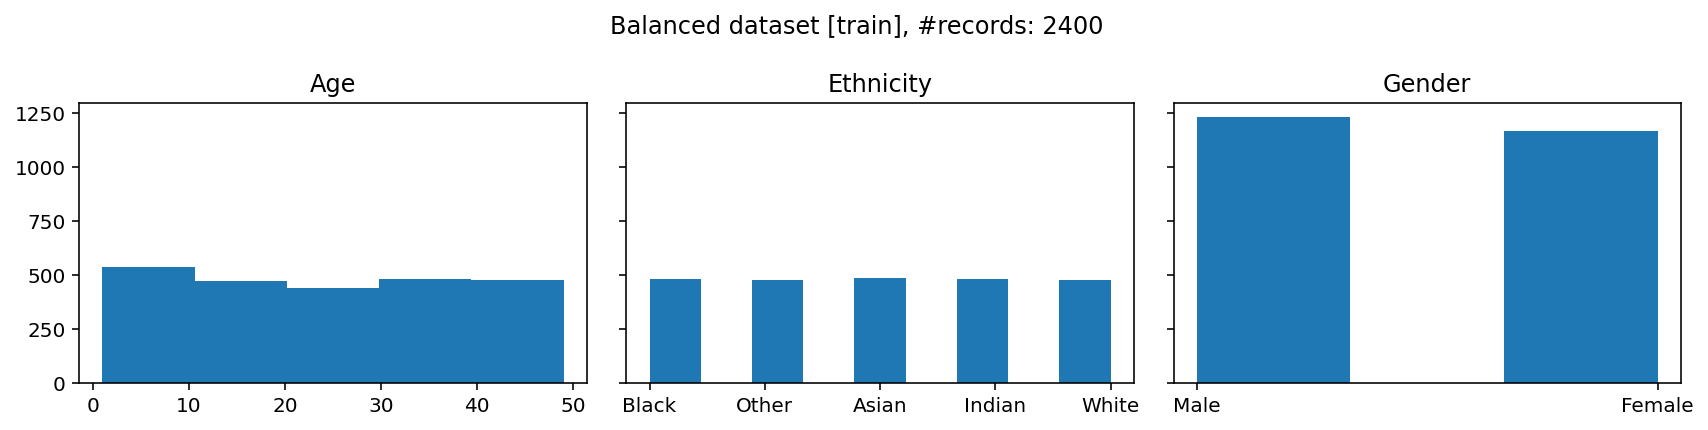

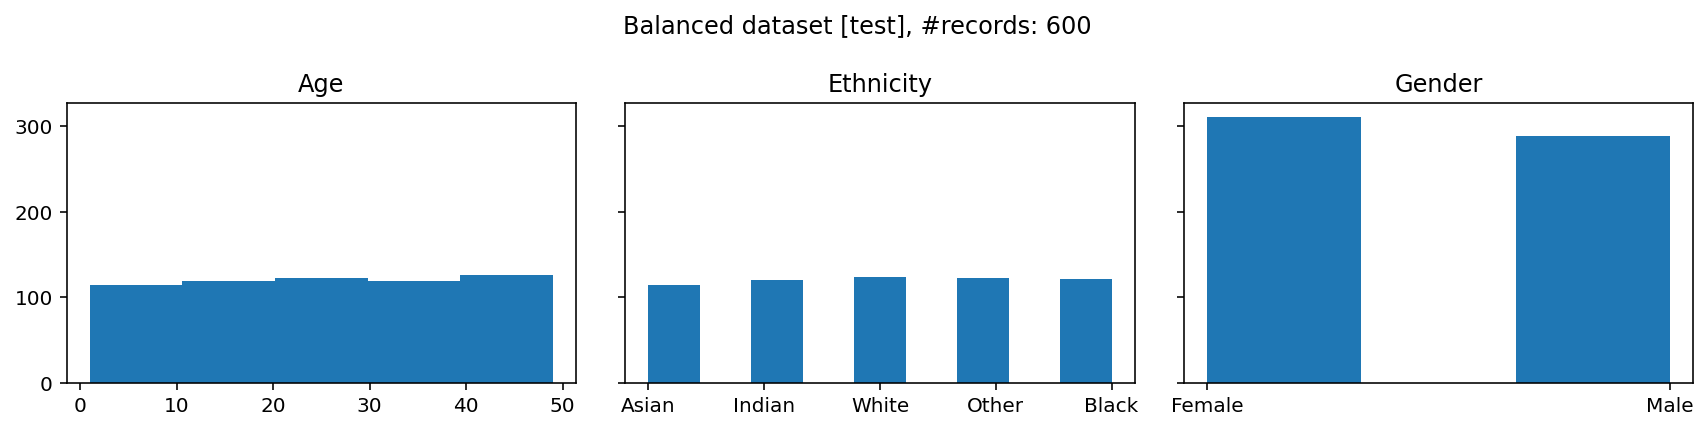

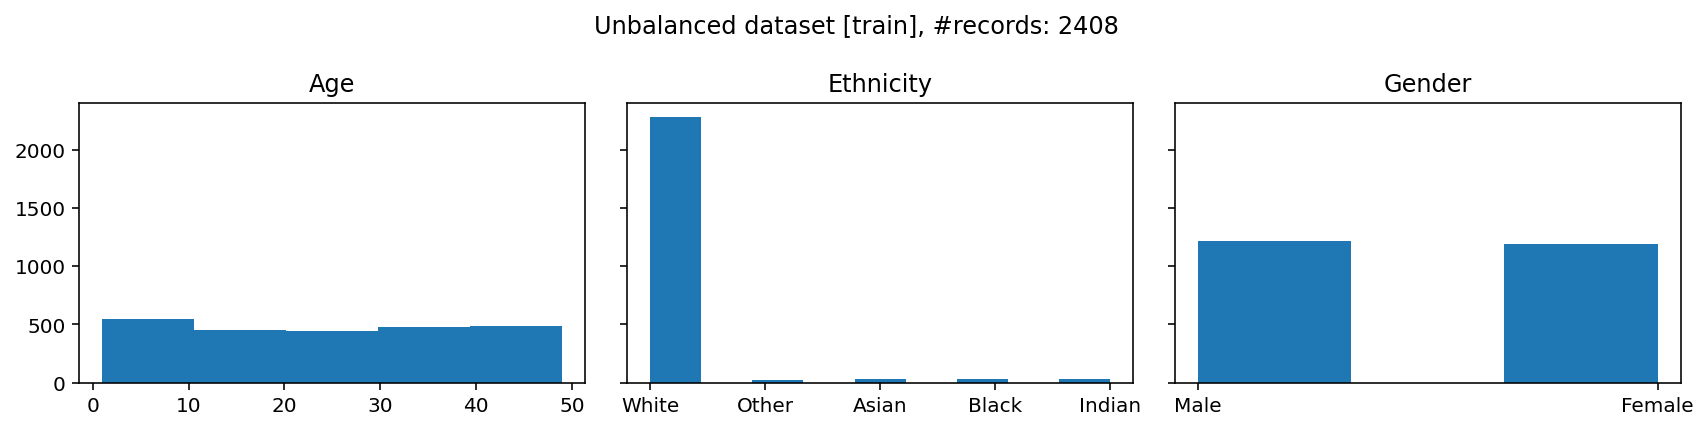

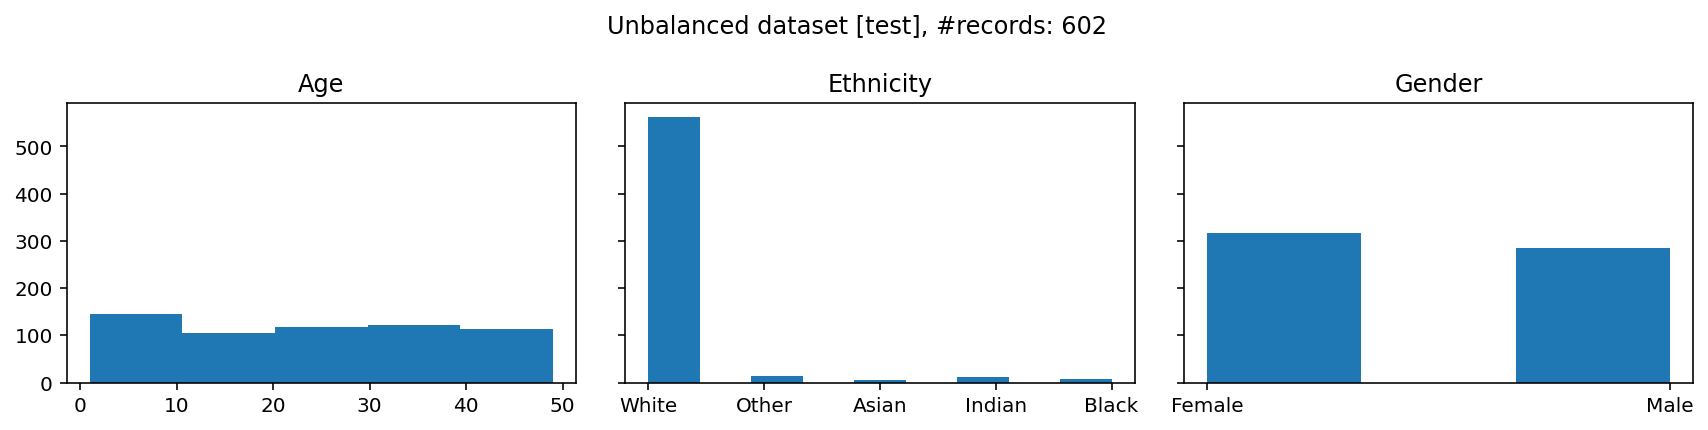

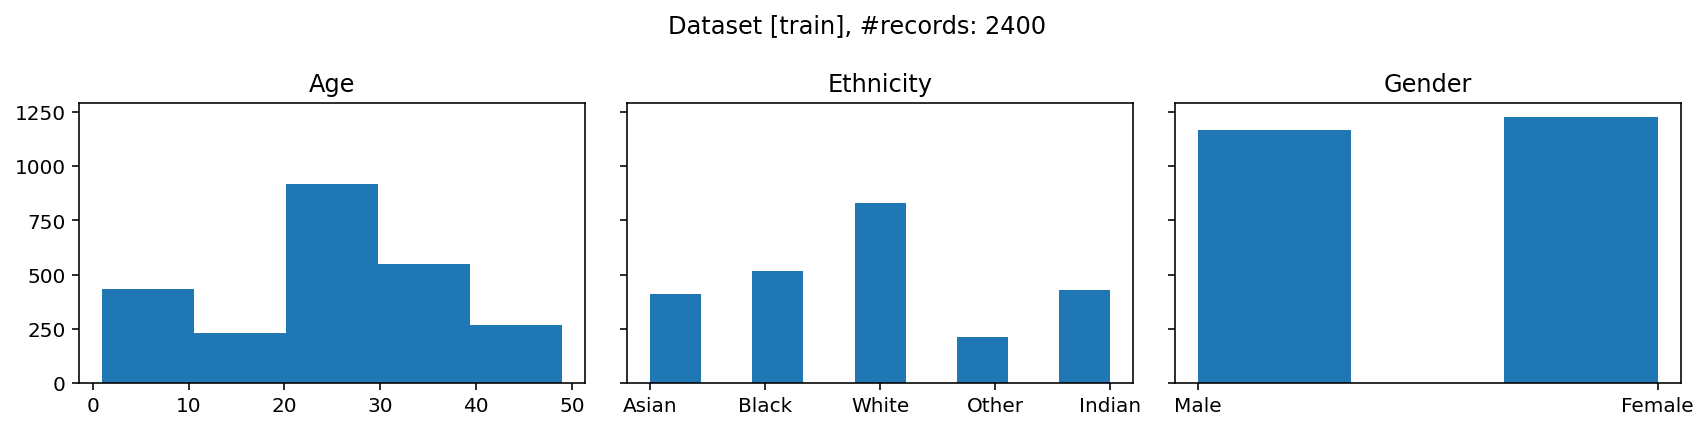

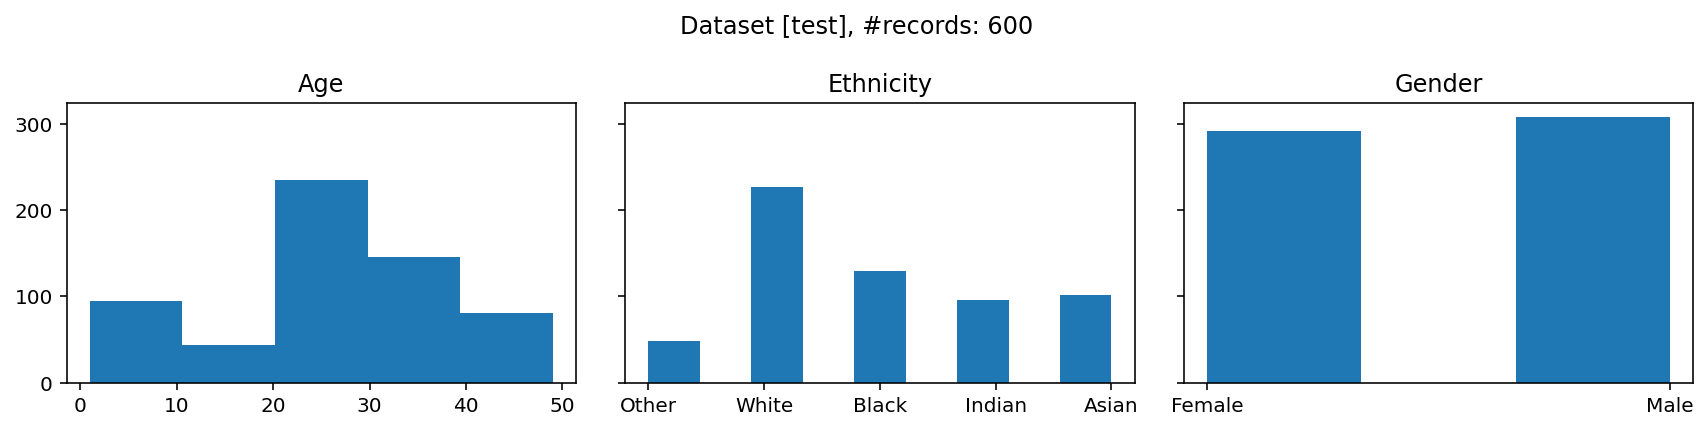

In [13]:
metrics = compare_model_behaviour(
    [balanced_df, unbalanced_df, df.sample(p['data_samples'], random_state=p['seed'])], 
    [standard_nn()] * 3,
    exp_ids=['Balanced dataset', 'Unbalanced dataset', 'Dataset']
)

In [14]:
def get_metrics_data(metrics):
    metrics_df = pd.DataFrame()
    for m in metrics:
        row = pd.Series(m)
        metrics_df = metrics_df.append(row, ignore_index=True)
    return metrics_df

In [15]:
get_metrics_data(metrics)

,experiment ID,data sample #,f1 [macro],White,Black,Asian,Indian,Other
0,Balanced dataset,3000.0,0.111422,0.111939,0.112233,0.104044,0.092377,0.124879
1,Unbalanced dataset,3010.0,0.152251,0.145065,0.146667,0.271429,0.106667,0.246234
2,Dataset,3000.0,0.105182,0.095242,0.063066,0.161404,0.083569,0.134259


In [16]:
render_row(2)

NameError: name 'render_row' is not defined